# Figure 1


In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from tqdm import tqdm
import plotly.graph_objects as go
import seaborn as sns
import geopandas as gpd
from matplotlib.colors import TwoSlopeNorm  # Use CenteredNorm for newer matplotlib versions
from scipy.stats import pearsonr

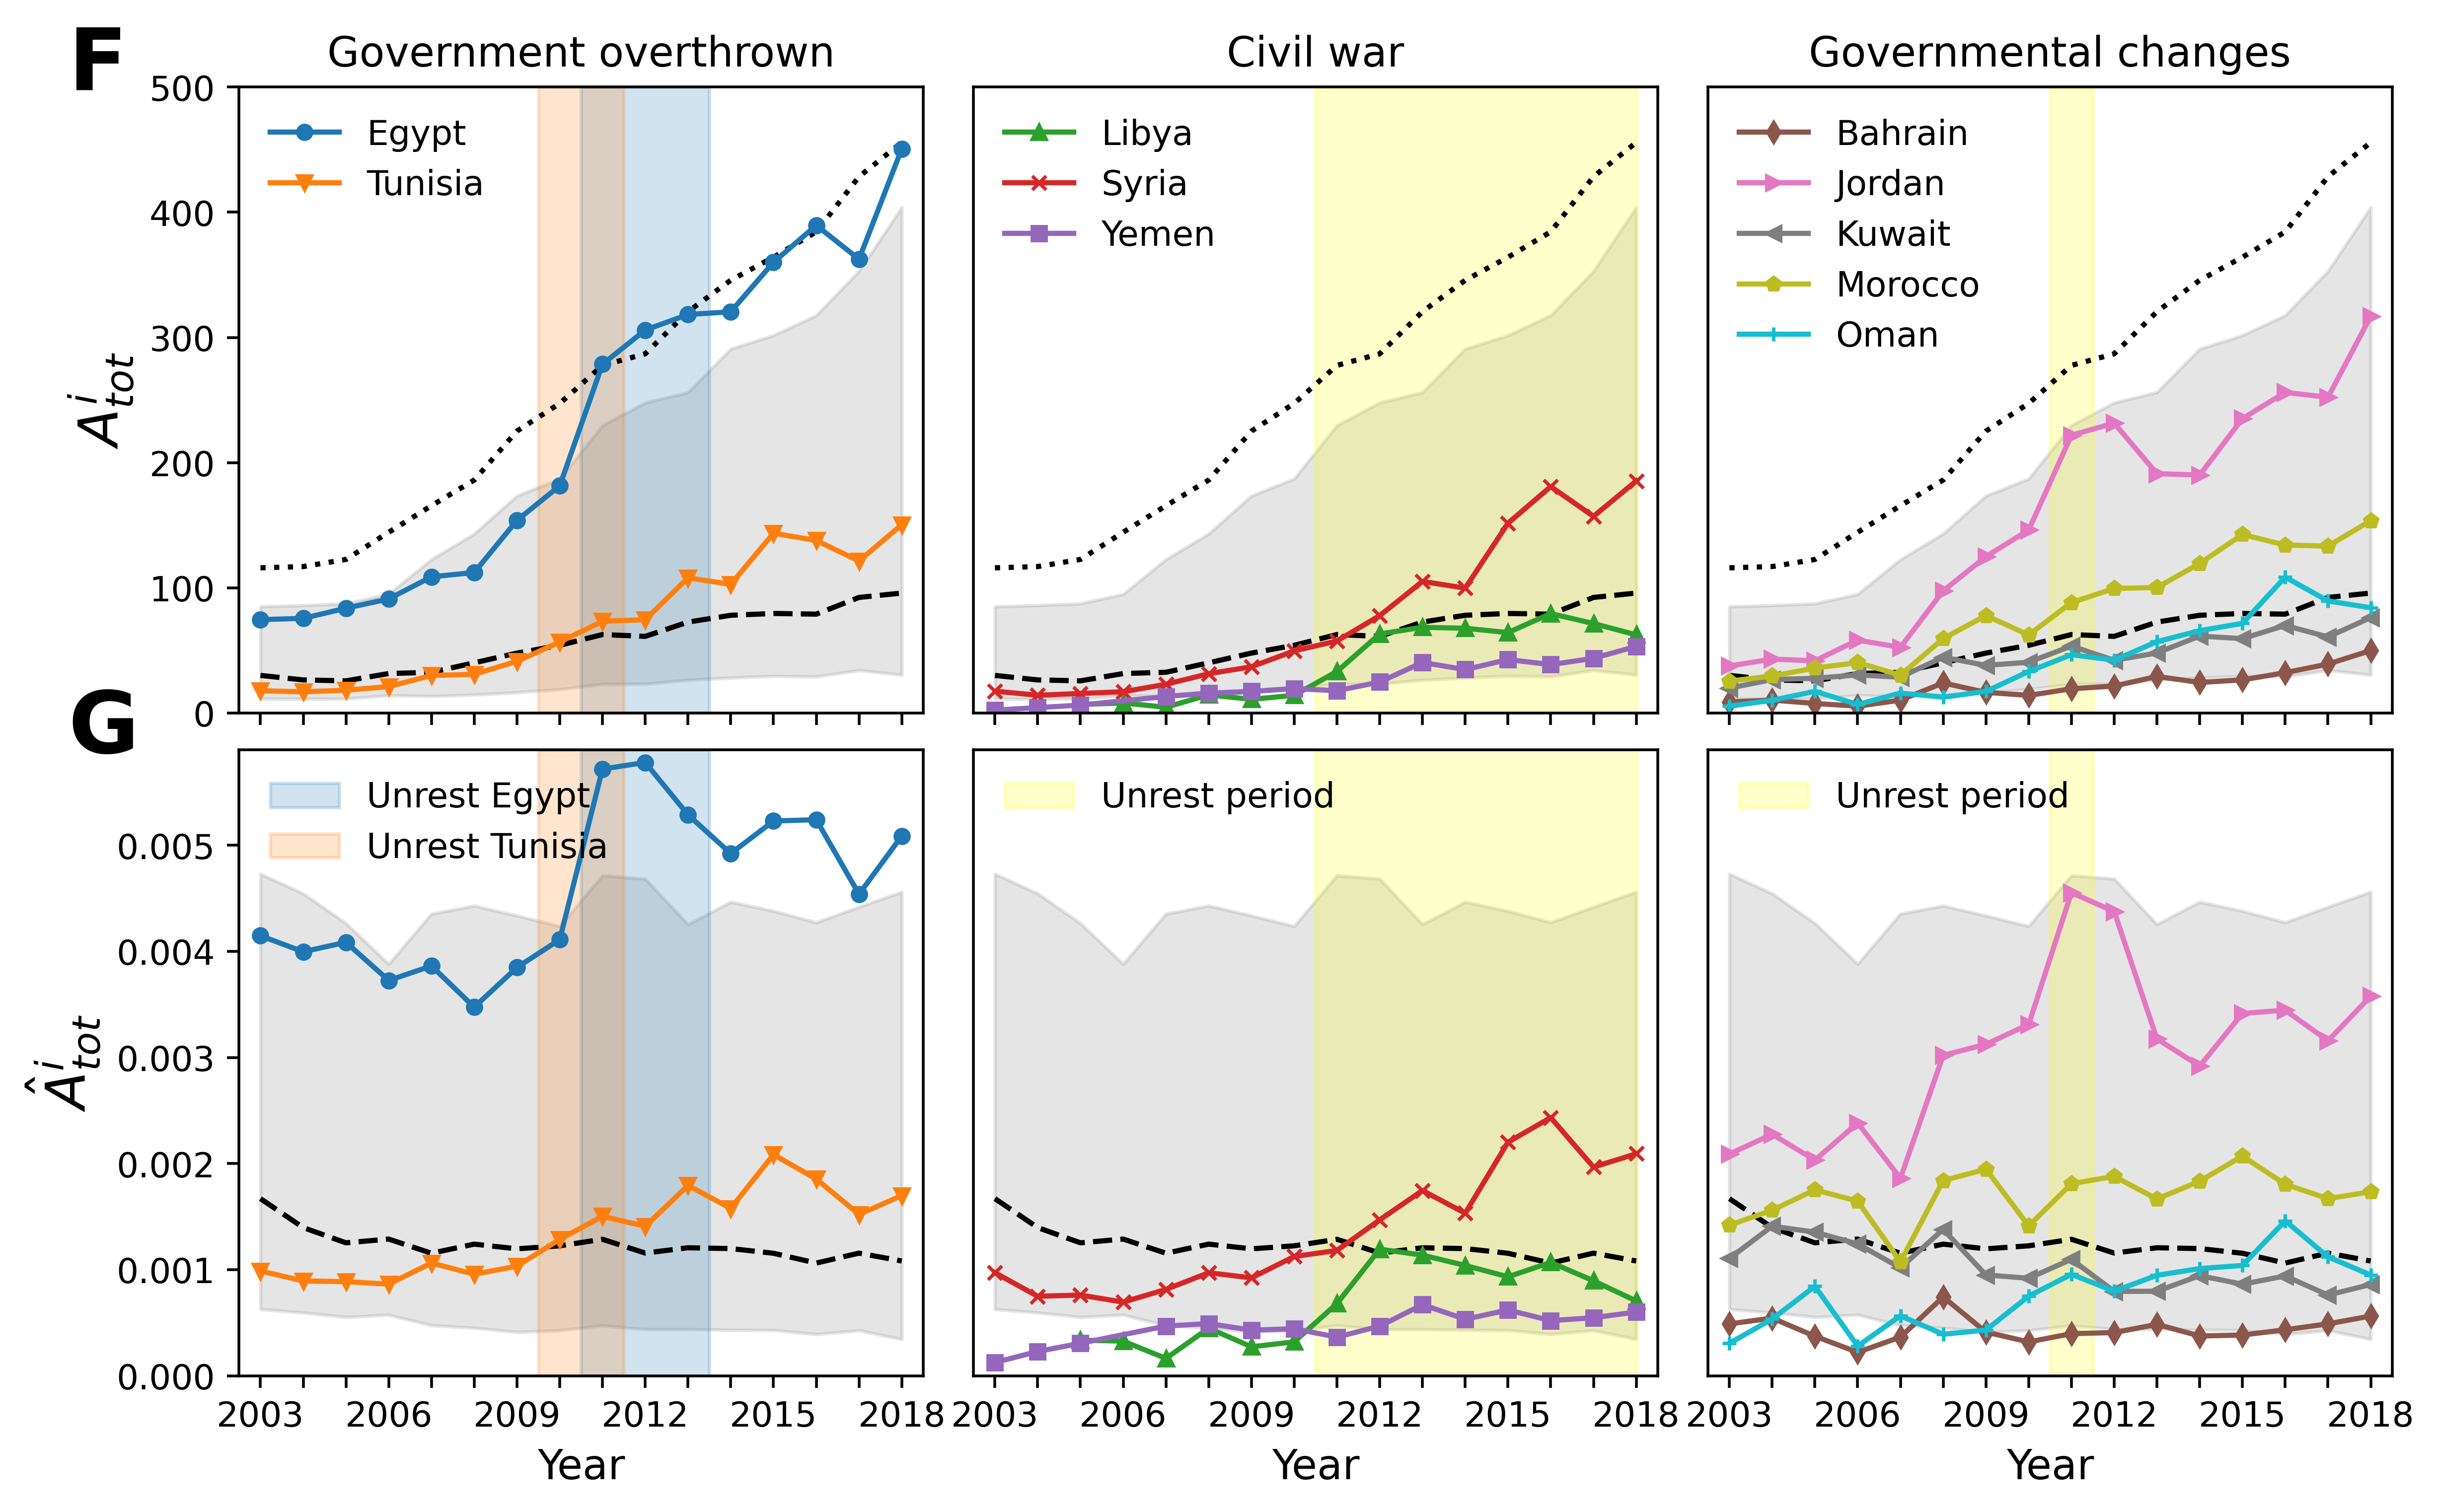

In [7]:
# Create a new figure with custom subplot layout
fig = plt.figure(figsize=(16, 10), dpi=500)

# Create grid specification for subplots
gs = fig.add_gridspec(10, 28)

ax6 = fig.add_subplot(gs[4:7, 10:16])
ax6.text(-0.25, 1.1, 'F', transform=ax6.transAxes, verticalalignment='top', fontsize=25,fontweight='bold')
ax6.set_ylabel('$A_{tot}^i$', fontsize=16)
ax6.set_title('Government overthrown', fontsize=12)
ax6.set_ylim(0, 500)

ax7 = fig.add_subplot(gs[4:7, 16:22])

ax7.set_title('Civil war', fontsize=12)
ax7.set_ylim(0, 500)
ax7.set_yticks([])

ax8 = fig.add_subplot(gs[4:7, 22:])

ax8.set_title('Governmental changes', fontsize=12)
ax8.set_ylim(0, 500)
ax8.set_yticks([])

ax9 = fig.add_subplot(gs[7:, 10:16])
ax9.text(-0.25, 1.1, 'G', transform=ax9.transAxes, verticalalignment='top', fontsize=25,fontweight='bold')
ax9.set_ylabel('$\hat{A}_{tot}^i$', fontsize=16)
ax9.set_ylim(0, 0.0059)
ax10 = fig.add_subplot(gs[7:, 16:22])
ax10.set_yticks([])
ax10.set_ylim(0, 0.0059)

ax11 = fig.add_subplot(gs[7:, 22:])
ax11.set_yticks([])
ax11.set_ylim(0, 0.0059)

plotFG([ax6, ax7, ax8, ax9, ax10, ax11])

for axis in [ax6, ax7, ax8]:
    axis.set_xlabel(' ')
    
# Show the plot layout
fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.075, hspace=0.2, wspace=0.7)
#fig.savefig('Final_figure1_ver16.pdf')
plt.show()

In [3]:
def plotFG(axis):
    df_all=pd.read_csv(r"C:\Users\Yasaman\Downloads\Attention-fractional counting.csv")
    df_all=df_all.rename(columns={'aggregated_value':'count', 'country':'Mention_country', 'affiliation_country':'Aff_country'})
    
    df_all=df_all[df_all['year'].isin(np.arange(2003, 2019, 1))]
    Country_list={'Egypt':'EGY', 'Tunisia':'TUN','Libya':'LBY','Syria':'SYR','Yemen':'YEM','Bahrain':'BHR','Jordan':'JOR','Kuwait':'KWT','Morocco':'MAR','Oman':'OMN'}
    rev_Country_list={Country_list[key]: key for key in Country_list}
    Unrest_times={'Egypt':[(2011, 2013)], 'Tunisia':[(2010, 2011)], 'Yemen':[(2011, 2017.5)], 'Syria':[(2011, 2017.5)], 'Libya':[(2011,2017.5)], 'Bahrain':[(2011,2011)], 'Kuwait':[(2011,2011)], 'Morocco':[(2011,2011)], 'Oman':[(2011,2011)], 'Jordan':[(2011, 2011)]}
    def  find_information(df,ax):
        
        df=df.merge(df.groupby(['year', 'Mention_country'])['count'].sum().reset_index().rename(columns={'count':'count_mention_country'}), on=['year', 'Mention_country'])
        df=df.merge(df.groupby('year')['count'].sum().reset_index().rename(columns={'count':'total_count'}),on='year')
        df['attention_share_mention_country']=df['count_mention_country']/df['total_count']

        df=df.merge(df[df['Aff_country']==df['Mention_country']].groupby(['year', 'Mention_country'])['count'].sum().reset_index().rename(columns={'count':'count_internal_mention'}), on=['year', 'Mention_country'])
        df=df.merge(df[df['Aff_country']!=df['Mention_country']].groupby(['year', 'Mention_country'])['count'].sum().reset_index().rename(columns={'count':'count_external_mention'}), on=['year', 'Mention_country'])
        df['external_attention_ratio']=df['count_external_mention']/df['count_mention_country']
        df['internal_attention_ratio']=df['count_internal_mention']/df['count_mention_country']
        new_df=df.drop_duplicates(['year', 'Mention_country'])[['year', 'Mention_country', 'attention_share_mention_country','count_mention_country','external_attention_ratio','internal_attention_ratio','count_internal_mention','total_count']].sort_values(by=['year'])
        new_df=new_df.rename(columns={'Mention_country':'countrycode'})
        new_df['percentile_rank_count'] = new_df.groupby('year')['count_mention_country'].rank(pct=True)
        new_df['percentile_rank_EAR'] = new_df.groupby('year')['external_attention_ratio'].rank(pct=True)
        new_df['percentile_rank_share'] =new_df.groupby('year')['attention_share_mention_country'].rank(pct=True)
        plot_time(new_df, 'count_mention_country', r'$TA_i^t$', log=False, ax=ax[:3], show_dates=False)
        plot_time(new_df, 'attention_share_mention_country', r'$\frac{TA_i^t}{\sum_i TA_i^t}$', log=False, show_mean=False, ax=ax[3:],legend_to_show=False)
  

    def plot_time(df, column, column_name,ax, log=True, show_mean=True, y_to_show=None, legend_to_show=True,show_dates=True):
      List=[['egy','tun'], ['lby', 'syr', 'yem'],  [ 'bhr', 'jor', 'kwt', 'mar', 'omn']]
      mean_df=df.groupby('year')[column].mean().reset_index()
      median_df=df.groupby('year')[column].median().reset_index()
      Q25_df=df.groupby('year')[column].quantile(.25).reset_index()
      Q75_df=df.groupby('year')[column].quantile(.75).reset_index()
      NC=0
      for k, country_list in enumerate(List):
        NB=0
        if show_mean:
          ax[k].plot(mean_df['year'].round(),mean_df[column],linestyle=':', color='k')
        ax[k].plot(median_df['year'].round(),median_df[column],linestyle='--', color='k')
        ax[k].fill_between(median_df['year'].round(),Q25_df[column],Q75_df[column], color='grey', alpha=0.2)
        markers=['o', 'v', '^', 'x', 's', 'd', '>', '<', 'p', '+']
        for country  in country_list:
          filt_df=df[df['countrycode']==country]
          #print(filt_df)
          if legend_to_show:
              ax[k].plot(filt_df['year'].round(),filt_df[column], label=rev_Country_list[country.upper()],color=f'C{NC}', marker=markers[NC], markersize=4)
          else:
            ax[k].plot(filt_df['year'].round(),filt_df[column],color=f'C{NC}', marker=markers[NC], markersize=4)
          NC+=1
          if country=='egy':
                color='C0'

          elif country =='tun':
            color='C1'

          else:
            color='yellow'
          NB+=1
          
          if NB<=2 and color!='yellow':
              for spans in Unrest_times[rev_Country_list[country.upper()]]:
                    start, end=spans
                    if not legend_to_show:
                        ax[k].axvspan(start-0.5, end+0.5, alpha=0.2, color=color, label=f'Unrest {rev_Country_list[country.upper()]}')
                    else:
                        ax[k].axvspan(start-0.5, end+0.5, alpha=0.2, color=color)

          elif NB==len(country_list) and color=='yellow':
             for spans in Unrest_times[rev_Country_list[country.upper()]]:
                    start, end=spans
                    if not legend_to_show:
                        ax[k].axvspan(start-0.5, end+0.5, alpha=0.2, color=color, label=f'Unrest period')
                    else:
                        ax[k].axvspan(start-0.5, end+0.5, alpha=0.2, color=color)
                        




      for axes in ax:

        axes.legend(loc='upper left', frameon=False)
        if y_to_show:
          axes.axhline(y_to_show,linestyle='-', color='cyan' )
        #axes.axvline(2011,linestyle='-', color='m' )
        #axes.axvline(2008,linestyle='-.', color='k' )
        if not show_dates:
            axes.set_xticks(np.arange(2003, 2019 ),[' ' for i in np.arange(2003, 2019 )] )
        else:
            axes.set_xticks(np.arange(2003, 2019 ),[str(tick) if i % 3 == 0 else '' for i, tick in enumerate(np.arange(2003, 2019 ))])
            #axes.set_xticklabels(np.arange(2003, 2019 )[::3],)
        axes.set_xlabel('Year', fontsize=12)
        axes.set_xlim(2002.5, 2018.5)
        if log:
          axes.set_yscale('log')
        
    social_sciences=['PSYC', 'SOCI', 'DECI', 'ARTS', 'ECON', 'BUSI']
    find_information(df_all[df_all['subjarea'].isin(social_sciences)],axis)




